# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 78203023.11it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

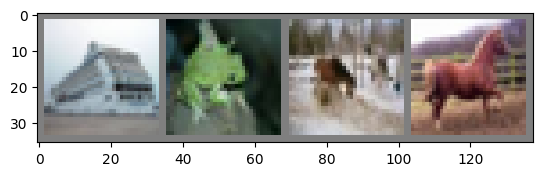

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # removes normalization from an image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))      # change the order of the axises: (C, H, W) -> (H, W, C)
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.n_in_channels = 3
        self.n_out_channels = 32

        self.block_srart = nn.Sequential(
            nn.Conv2d(in_channels=self.n_in_channels, out_channels=self.n_out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(self.n_out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.n_out_channels, out_channels=self.n_out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(self.n_out_channels)
        )

        self.conv1 = nn.Conv2d(in_channels=self.n_in_channels, out_channels=self.n_out_channels, kernel_size=1)

        self.block_end = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(self.n_out_channels // 4))
        )
        self.flatten = nn.Flatten()
        self.logits = nn.Linear(in_features=(self.n_out_channels * 4 * 4), out_features=n_classes)

    def forward(self, x):
        out = self.block_srart(x)
        out += self.conv1(x)
        out = self.block_end(out)
        out = self.flatten(out)
        out = self.logits(out)

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (block_srart): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (block_end): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (logits): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = nn.CrossEntropyLoss()

    for data, target in loader:

        output = net(data.to(device))
        loss = criterion(output, target.to(device))

        loss_log.append(loss.item())

        correct = (torch.argmax(output, dim=1) ==  target.to(device)).sum()
        total = target.shape[0]
        acc = correct / total

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:

        optimizer.zero_grad()
        output = net(data.to(device))
        loss = criterion(output, target.to(device))

        loss_log.append(loss.item())

        loss.backward()
        optimizer.step()
        correct = (torch.argmax(output, dim=1) ==  target.to(device)).sum()
        total = target.shape[0]
        acc = correct / total

        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4618621617828034, train acc: 0.48085335599874884
 val loss: 1.2237425859938276, val acc: 0.5664007093044038

Epoch 1
 train loss: 1.152556364235538, train acc: 0.5985407417391511
 val loss: 1.1504318950024057, val acc: 0.6023049646235527

Epoch 2
 train loss: 1.0411182441484776, train acc: 0.6371237595294904
 val loss: 1.0673286181815127, val acc: 0.6331338654173181

Epoch 3
 train loss: 0.9866094575067761, train acc: 0.6580128623972863
 val loss: 1.0271338470438693, val acc: 0.6445478723404255

Epoch 4
 train loss: 0.9537017662520818, train acc: 0.6688960890883283
 val loss: 0.990643066041013, val acc: 0.6561613476022761

Epoch 5
 train loss: 0.924217839454602, train acc: 0.6794895861004998
 val loss: 0.9473815387867867, val acc: 0.6737588654173181

Epoch 6
 train loss: 0.900367083671542, train acc: 0.686463502251034
 val loss: 1.0279941822620149, val acc: 0.6497562058428501

Epoch 7
 train loss: 0.8798608668761454, train acc: 0.6920948681273452
 val loss: 0.941

Посчитайте точность на тестовой выборке:

In [12]:
comparing_test_loss = []
comparing_test_acc = []

In [13]:
test_loss_base, test_acc_base = test(net, test_loader)

print(f'Test Loss: {test_loss_base}')
print(f'Test Accuracy: {test_acc_base}')

comparing_test_loss.append(test_loss_base)
comparing_test_acc.append(test_acc_base)

Test Loss: 0.8603764537033761
Test Accuracy: 0.7034235668789809


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

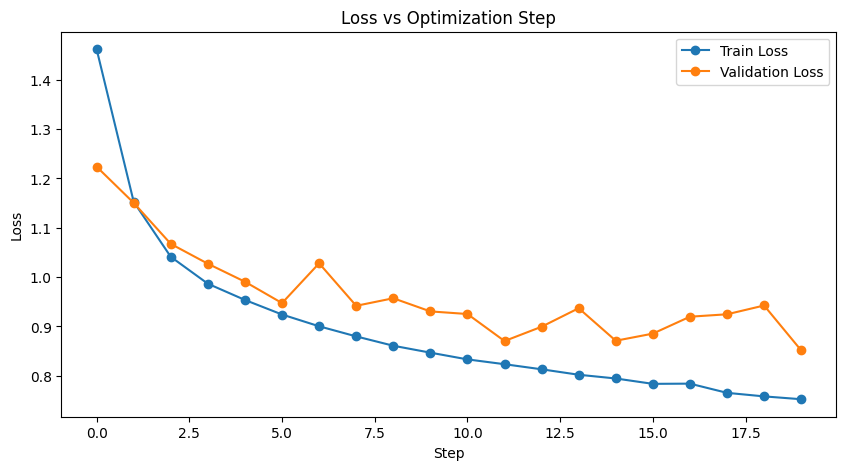

In [14]:
num_batches = len(train_loader)      # number of batches in one epoch

epoch_loss_log = [np.mean(train_loss_log[i * num_batches : (i + 1) * num_batches]) for i in range(20)]
epochs = range(20)

plt.figure(figsize=(10, 5))
plt.plot(epochs, epoch_loss_log, label="Train Loss", linestyle='-', marker='o')
plt.plot(epochs, val_loss_log, label="Validation Loss", linestyle='-', marker='o')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss vs Optimization Step')
plt.legend()
plt.show()

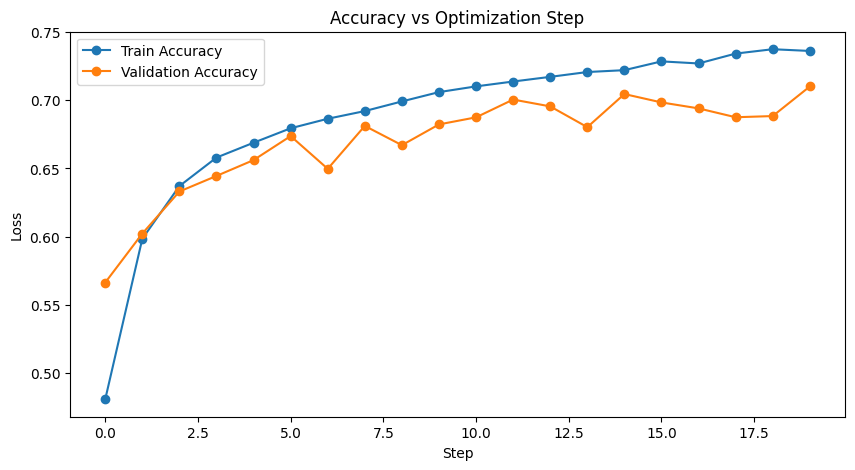

In [15]:
epoch_acc_log = [np.mean(train_acc_log[i * num_batches : (i + 1) * num_batches]) for i in range(20)]

plt.figure(figsize=(10, 5))
plt.plot(epochs, epoch_acc_log, label="Train Accuracy", linestyle='-', marker='o')
plt.plot(epochs, val_acc_log, label="Validation Accuracy", linestyle='-', marker='o')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Accuracy vs Optimization Step')
plt.legend()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [16]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4650089575124179, train acc: 0.4800576194984603
 val loss: 1.2702559991085782, val acc: 0.5488918441407225

Epoch 1
 train loss: 1.1433132415061895, train acc: 0.5996629341864717
 val loss: 1.1353814152961081, val acc: 0.6052083333756061

Epoch 2
 train loss: 1.0468226642887597, train acc: 0.6345651606319156
 val loss: 1.2439217349316212, val acc: 0.5742021276595745

Epoch 3
 train loss: 0.9867827805130311, train acc: 0.6534792047531993
 val loss: 1.0249440505149516, val acc: 0.6491134752618506

Epoch 4
 train loss: 0.9499902496390195, train acc: 0.6699978781138739
 val loss: 1.0016177385411364, val acc: 0.6495124114320633

Epoch 5
 train loss: 0.916657315366229, train acc: 0.6801629016342721
 val loss: 0.9737571348535253, val acc: 0.6642952127659575

Epoch 6
 train loss: 0.8995804558397429, train acc: 0.6869572669104205
 val loss: 0.925792825729289, val acc: 0.6843971632896586

Epoch 7
 train loss: 0.8823860354680684, train acc: 0.693616969275954
 val loss: 0.88

Посчитайте точность на тестовой выборке:

In [17]:
test_loss_Multi, test_acc_Multi = test(net, test_loader)

print(f'Test Loss: {test_loss_Multi}')
print(f'Test Accuracy: {test_acc_Multi}')

comparing_test_loss.append(test_loss_Multi)
comparing_test_acc.append(test_acc_Multi)

Test Loss: 0.8233376671174529
Test Accuracy: 0.7191480891719745


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [18]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.8587565332705622, train acc: 0.3467207495429616
 val loss: 1.638525204455599, val acc: 0.4318484042553192

Epoch 1
 train loss: 1.5726113583095767, train acc: 0.44760789372149506
 val loss: 1.4885202301309464, val acc: 0.4777482269926274

Epoch 2
 train loss: 1.4449750012845837, train acc: 0.49220994392740225
 val loss: 1.4079474540466959, val acc: 0.5046320922831271

Epoch 3
 train loss: 1.3608930389885492, train acc: 0.5223459128487916
 val loss: 1.3147898729811323, val acc: 0.5400709220703612

Epoch 4
 train loss: 1.299654203642439, train acc: 0.5451692675105833
 val loss: 1.2577711716611335, val acc: 0.5643838652904998

Epoch 5
 train loss: 1.2457506299236794, train acc: 0.5637895012686414
 val loss: 1.2153142018521086, val acc: 0.577969858240574

Epoch 6
 train loss: 1.2047258231931892, train acc: 0.5812712197329923
 val loss: 1.2024688647148456, val acc: 0.5802969859001484

Epoch 7
 train loss: 1.1603550025052518, train acc: 0.5961290481321555
 val loss: 1.

In [19]:
test_loss_worst, test_acc_worst = test(net, test_loader)

print(f'Test Loss: {test_loss_worst}')
print(f'Test Accuracy: {test_acc_worst}')

comparing_test_loss.append(test_loss_worst)
comparing_test_acc.append(test_acc_worst)

Test Loss: 0.937262878676129
Test Accuracy: 0.675656847133758


Да, действительно, выросла ошибка и упала точность классификации. 

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

В библиотеке представлено 16 споособов уменьшения длины шага. Выберем несколько из них и посмотрим, как изменится качество на тестовой выборке при их использовании.

### **lr_scheduler.StepLR**: 

Уменьшает скорость обучения, умножая на заданный коэффициент `gamma`, через равные интервалы шагов `step_size`.

In [20]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.474118007166512, train acc: 0.47447114136798724
 val loss: 1.3061016907083227, val acc: 0.5509308510638298

Epoch 1
 train loss: 1.1416789240985292, train acc: 0.6036742622717207
 val loss: 1.0678414996634138, val acc: 0.6269946808510638

Epoch 2
 train loss: 1.0314787007337078, train acc: 0.6388539762340036
 val loss: 1.0251931697764296, val acc: 0.6416445037151904

Epoch 3
 train loss: 0.9718706988111493, train acc: 0.6609468856720864
 val loss: 1.0296380740530948, val acc: 0.6384530143534883

Epoch 4
 train loss: 0.9361230194895533, train acc: 0.6741805954868658
 val loss: 0.9764390620779484, val acc: 0.6600620569066799

Epoch 5
 train loss: 0.8516830462533334, train acc: 0.7034392140029335
 val loss: 0.903614126114135, val acc: 0.6930407803109352

Epoch 6
 train loss: 0.8368275295772761, train acc: 0.7101478845807273
 val loss: 0.8860618593844961, val acc: 0.6952127659574469

Epoch 7
 train loss: 0.8241969190633275, train acc: 0.713979661900557
 val loss: 0.8

In [21]:
test_loss_Step, test_acc_Step = test(net, test_loader)

print(f'Test Loss: {test_loss_Step}')
print(f'Test Accuracy: {test_acc_Step}')

comparing_test_loss.append(test_loss_Step)
comparing_test_acc.append(test_acc_Step)

Test Loss: 0.828445405527285
Test Accuracy: 0.7132762738853503


### **lr_scheduler.ExponentialLR**: 

Уменьшает скорость обучения экспоненциально с каждым шагом, то есть на каждом шаге:  `lr = lr * gamma`.

In [22]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.501086419199677, train acc: 0.4646040088951697
 val loss: 1.29090824228652, val acc: 0.5475620567798615

Epoch 1
 train loss: 1.2049405916953217, train acc: 0.5750522330212636
 val loss: 1.168801828140908, val acc: 0.5938608156873825

Epoch 2
 train loss: 1.078948245950765, train acc: 0.6270893184532849
 val loss: 1.0730426986166772, val acc: 0.6225398936170212

Epoch 3
 train loss: 1.0001256975874822, train acc: 0.6536954818957467
 val loss: 1.0205374469148352, val acc: 0.649468085106383

Epoch 4
 train loss: 0.953220554853924, train acc: 0.6690225908481661
 val loss: 0.9575088724176934, val acc: 0.6668661348363186

Epoch 5
 train loss: 0.9155295119642993, train acc: 0.6837131105349749
 val loss: 0.9873930487226933, val acc: 0.6550753547790202

Epoch 6
 train loss: 0.8810389903825205, train acc: 0.695212522960886
 val loss: 0.9200099067485079, val acc: 0.6767287234042553

Epoch 7
 train loss: 0.8583147836341718, train acc: 0.7022884565471949
 val loss: 0.8926271

In [23]:
test_loss_Exponential, test_acc_Exponential = test(net, test_loader)

print(f'Test Loss: {test_loss_Exponential}')
print(f'Test Accuracy: {test_acc_Exponential}')

comparing_test_loss.append(test_loss_Exponential)
comparing_test_acc.append(test_acc_Exponential)

Test Loss: 0.8166178350995301
Test Accuracy: 0.7190485668789809


### **lr_scheduler.LinearLR:**

Изменяет скорость обучения по линейной функции в течение заданного числа шагов: `start_factor` - начальный множитель для LR относительно его исходного значения, `end_factor` - конечный множитель для LR, `total_iters` - количество шагов, за которые происходит линейное изменение LR.

In [24]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=10)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4816650329821723, train acc: 0.46874183863129
 val loss: 1.2584763405170847, val acc: 0.5587322696726373

Epoch 1
 train loss: 1.148995174677324, train acc: 0.5981775594149908
 val loss: 1.0871234427107141, val acc: 0.6182624114320633

Epoch 2
 train loss: 1.0404079104254407, train acc: 0.6375930399737803
 val loss: 1.1036459276016721, val acc: 0.6232047872340426

Epoch 3
 train loss: 0.9754183823055498, train acc: 0.6623261622144709
 val loss: 1.0091414885318026, val acc: 0.6523714539852549

Epoch 4
 train loss: 0.9264314012292099, train acc: 0.6789264494801788
 val loss: 0.9755660840805541, val acc: 0.6669991135597229

Epoch 5
 train loss: 0.8879273919017485, train acc: 0.6927110538622143
 val loss: 0.9450671540929916, val acc: 0.6762411348363186

Epoch 6
 train loss: 0.8547381169181419, train acc: 0.7053285780510911
 val loss: 0.8910904404964853, val acc: 0.6949246454746165

Epoch 7
 train loss: 0.8241357809337881, train acc: 0.7142734722637825
 val loss: 0.87

In [25]:
test_loss_Linear, test_acc_Linear = test(net, test_loader)

print(f'Test Loss: {test_loss_Linear}')
print(f'Test Accuracy: {test_acc_Linear}')

comparing_test_loss.append(test_loss_Linear)
comparing_test_acc.append(test_acc_Linear)

Test Loss: 0.845739804635382
Test Accuracy: 0.7126791401273885


### **lr_scheduler.CosineAnnealingLR:**

Уменьшает LR по косинусоидальной кривой до минимального значения `eta_min` (`T_max` — количество шагов для уменьшения LR до eta_min).

In [36]:
num_steps = len(train_loss_log) 

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps, eta_min=0.001)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4871313541419326, train acc: 0.4726266649567013
 val loss: 1.3342948928792426, val acc: 0.5269946808510638

Epoch 1
 train loss: 1.168018136534438, train acc: 0.5910240924990373
 val loss: 1.1204968208962298, val acc: 0.6108599292471054

Epoch 2
 train loss: 1.0613367047562678, train acc: 0.6301661661163762
 val loss: 1.0389360328938098, val acc: 0.6387411348363187

Epoch 3
 train loss: 1.001697669408439, train acc: 0.6544177657507455
 val loss: 1.0647718290065198, val acc: 0.633067376055616

Epoch 4
 train loss: 0.9599066508535493, train acc: 0.6693286432644567
 val loss: 0.9694414270685074, val acc: 0.6669991135597229

Epoch 5
 train loss: 0.9243011026757291, train acc: 0.6781307130888568
 val loss: 0.9661811640922059, val acc: 0.6649822696726373

Epoch 6
 train loss: 0.8965808512741731, train acc: 0.689409767578899
 val loss: 0.9355430537081779, val acc: 0.6750664893617021

Epoch 7
 train loss: 0.881559450458565, train acc: 0.6938495691559214
 val loss: 0.9228

In [37]:
test_loss_CosineAnnealing, test_acc_CosineAnnealing = test(net, test_loader)

print(f'Test Loss: {test_loss_CosineAnnealing}')
print(f'Test Accuracy: {test_acc_CosineAnnealing}')

comparing_test_loss.append(test_loss_CosineAnnealing)
comparing_test_acc.append(test_acc_CosineAnnealing)

Test Loss: 0.8658514592298276
Test Accuracy: 0.716062898089172


Для наглядности сведём результаты в таблицу и посмотрим, получилось ли добиться лучшего качества.

In [38]:
models_list = ["Base", "MultiStepLR", "Worst (low LR)", "StepLR", "ExponentialLR", "LinearLR", "CosineAnnealingLR"]

import pandas as pd

comparing_df = pd.DataFrame({
    "Scheduler": models_list,
    "Test Loss": comparing_test_loss,
    "Test Accuracy": comparing_test_acc
})

comparing_df

,Scheduler,Test Loss,Test Accuracy
0,Base,0.860376,0.703424
1,MultiStepLR,0.823338,0.719148
2,Worst (low LR),0.937263,0.675657
3,StepLR,0.828445,0.713276
4,ExponentialLR,0.816618,0.719049
5,LinearLR,0.845740,0.712679
6,CosineAnnealingLR,0.865851,0.716063


In [51]:
best_loss_model = comparing_df.loc[comparing_df['Test Loss'].idxmin(), 'Scheduler']
best_acc_model = comparing_df.loc[comparing_df['Test Accuracy'].idxmax(), 'Scheduler']

print(f'Модель с лучшим loss: {best_loss_model}')
print(f'Модель с лучшим accuracy: {best_acc_model}')

Модель с лучшим loss: ExponentialLR
Модель с лучшим accuracy: MultiStepLR


Все варианты моделей с уменьшением длины шага превзошли по качеству на тесте базовую модель с фиксированной скоростью обучения. По точности лучшей всё равно оказалась MultiStepLR, но к ней получилось приблизить ExponentialLR, которая превзошла MultiStepLR по loss.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

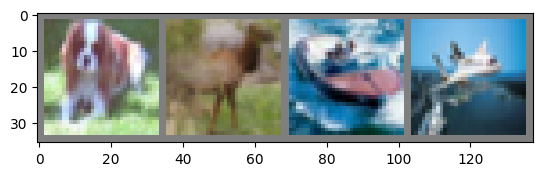

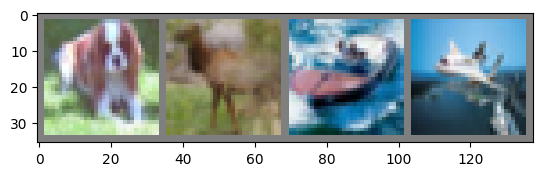

In [53]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [54]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4856852428132916, train acc: 0.46916215075435325
 val loss: 1.2763254289931438, val acc: 0.5419104610351806

Epoch 1
 train loss: 1.1885432753528058, train acc: 0.5804591603863174
 val loss: 1.1488552755497872, val acc: 0.6013297872340425

Epoch 2
 train loss: 1.0623794449748678, train acc: 0.6275830831126713
 val loss: 1.0342315564764306, val acc: 0.6430407803109351

Epoch 3
 train loss: 1.0000332446813147, train acc: 0.6543892008512939
 val loss: 1.0134206502995593, val acc: 0.6530806739279564

Epoch 4
 train loss: 0.9578462245259468, train acc: 0.669536759038294
 val loss: 1.0408444376702004, val acc: 0.6405141845662543

Epoch 5
 train loss: 0.9248667871494398, train acc: 0.678216407678245
 val loss: 0.9333385967193766, val acc: 0.6758200355032657

Epoch 6
 train loss: 0.9103110674530323, train acc: 0.6872592387513226
 val loss: 0.9684668135135732, val acc: 0.664472517815042

Epoch 7
 

Посчитайте точность на тестовой выборке:

In [57]:
test_loss_aug_0, test_acc_aug_0 = test(net, test_loader)

print(f'Test Loss: {test_loss_aug_0}')
print(f'Test Accuracy: {test_acc_aug_0}')

comparing_test_loss_aug = []
comparing_test_acc_aug = []

comparing_test_loss_aug.append(test_loss_aug_0)
comparing_test_acc_aug.append(test_acc_aug_0)

Test Loss: 0.7995845033864307
Test Accuracy: 0.7275079617834395


Качество на тесте приятно выросло.

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

### **RandomRotation:**

Поворачивает изображение на случайный угол из заданного диапазона.

In [58]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.61242358427379, train acc: 0.42029984984580954
 val loss: 1.434876397315492, val acc: 0.48147163124794656

Epoch 1
 train loss: 1.3943133620065136, train acc: 0.504472447160829
 val loss: 1.3113909371355748, val acc: 0.5344193263256803

Epoch 2
 train loss: 1.2987203162156686, train acc: 0.540782515048109
 val loss: 1.280535786709887, val acc: 0.5500664893617021

Epoch 3
 train loss: 1.2406625555899722, train acc: 0.5614186146141624
 val loss: 1.2065751580481834, val acc: 0.5720079787234043

Epoch 4
 train loss: 1.1953965185765156, train acc: 0.5761785061529393
 val loss: 1.196476504396885, val acc: 0.5779920212765958

Epoch 5
 train loss: 1.1637014901398304, train acc: 0.5906201032223606
 val loss: 1.2088807757864608, val acc: 0.5798537234042553

Epoch 6
 train loss: 1.1399876056903022, train acc: 0.5972757247945726
 val loss: 1.1216212533889933, val acc: 0.6031471632896586

Epoch 7
 tra

In [59]:
test_loss_aug_1, test_acc_aug_1 = test(net, test_loader)

print(f'Test Loss: {test_loss_aug_1}')
print(f'Test Accuracy: {test_acc_aug_1}')

comparing_test_loss_aug.append(test_loss_aug_1)
comparing_test_acc_aug.append(test_acc_aug_1)

Test Loss: 0.9196044309124066
Test Accuracy: 0.6803343949044586


### **ColorJitter:**

Случайно изменяет яркость `brightness`, контраст `contrast`, насыщенность `saturation` и оттенок `hue` изображения в диапозоне до уровня указанных изменений.

In [60]:
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6702718226957582, train acc: 0.40519717951361395
 val loss: 1.4670947643036538, val acc: 0.478656914893617

Epoch 1
 train loss: 1.3355315581536162, train acc: 0.5365875555130856
 val loss: 1.264461094014188, val acc: 0.5591090425531915

Epoch 2
 train loss: 1.2112206567140122, train acc: 0.5797491185843836
 val loss: 1.2120370806531704, val acc: 0.5798980497299356

Epoch 3
 train loss: 1.1586458093505454, train acc: 0.6018624314442413
 val loss: 1.1765789922247543, val acc: 0.598404255319149

Epoch 4
 train loss: 1.1120062700355293, train acc: 0.617919985729336
 val loss: 1.138472812226478, val acc: 0.6083554965384463

Epoch 5
 train loss: 1.0806827805595816, train acc: 0.6288195351577982
 val loss: 1.079319222937239, val acc: 0.6287012412192974

Epoch 6
 train loss: 1.0560475361194646, train acc: 0.6371849700127484
 val loss: 1.0634076607988237, val acc: 0.6277703901554675

Epoch 7
 tra

In [61]:
test_loss_aug_2, test_acc_aug_2 = test(net, test_loader)

print(f'Test Loss: {test_loss_aug_2}')
print(f'Test Accuracy: {test_acc_aug_2}')

comparing_test_loss_aug.append(test_loss_aug_2)
comparing_test_acc_aug.append(test_acc_aug_2)

Test Loss: 0.8718455236428863
Test Accuracy: 0.7019307324840764


### **RandomGrayscale:**

Преобразует изображение в градации серого с заданной вероятностью.

In [62]:
transform = transforms.Compose([
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5060051191441537, train acc: 0.46333083058188124
 val loss: 1.2695606926654248, val acc: 0.5472074468085106

Epoch 1
 train loss: 1.199896539478023, train acc: 0.5805979041992202
 val loss: 1.1429070011098335, val acc: 0.6053191489361702

Epoch 2
 train loss: 1.0716354123417158, train acc: 0.626334388905513
 val loss: 1.0760452914745249, val acc: 0.630407801587531

Epoch 3
 train loss: 1.0089956305144692, train acc: 0.6477335792790819
 val loss: 1.0195606231689454, val acc: 0.6477393617021276

Epoch 4
 train loss: 0.9595393624558527, train acc: 0.6669944829871057
 val loss: 1.0134485021550605, val acc: 0.6476063829787234

Epoch 5
 train loss: 0.921608280220241, train acc: 0.6789101267427587
 val loss: 1.0096264905117929, val acc: 0.6480496454746165

Epoch 6
 train loss: 0.899763281700598, train acc: 0.6877203578269024
 val loss: 0.943669855594635, val acc: 0.6761524823117764

Epoch 7
 tra

In [63]:
test_loss_aug_3, test_acc_aug_3 = test(net, test_loader)

print(f'Test Loss: {test_loss_aug_3}')
print(f'Test Accuracy: {test_acc_aug_3}')

comparing_test_loss_aug.append(test_loss_aug_3)
comparing_test_acc_aug.append(test_acc_aug_3)

Test Loss: 0.8005013613943841
Test Accuracy: 0.7232285031847133


### **Объединение RandomHorizontalFlip,  RandomGrayscale:**

Не включила RandomRotation, ColorJitter в аугментацию, так как они ухудшили качество на тесте, а не улучшили.

In [82]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5011332159286443, train acc: 0.46433876343139563
 val loss: 1.2523813255289769, val acc: 0.5533244680851064

Epoch 1
 train loss: 1.1868267641206982, train acc: 0.5848336706867602
 val loss: 1.107084186787301, val acc: 0.6134751773895102

Epoch 2
 train loss: 1.072869979376331, train acc: 0.6282604793307986
 val loss: 1.0748482308489211, val acc: 0.6297872340425532

Epoch 3
 train loss: 1.0128031924394192, train acc: 0.6501860799475605
 val loss: 1.0090804379037086, val acc: 0.6542996454746165

Epoch 4
 train loss: 0.9701482426967656, train acc: 0.664754178667853
 val loss: 0.9960732173412404, val acc: 0.6559840425531915

Epoch 5
 train loss: 0.9488474089223244, train acc: 0.6745152129115745
 val loss: 0.9535086951357253, val acc: 0.6650265957446808

Epoch 6
 train loss: 0.917255472766416, train acc: 0.6836763842668132
 val loss: 0.9389517568527384, val acc: 0.6699689718002969

Epoch 7
 t

In [83]:
test_loss_aug_03, test_acc_aug_03 = test(net, test_loader)

print(f'Test Loss: {test_loss_aug_03}')
print(f'Test Accuracy: {test_acc_aug_03}')

comparing_test_loss_aug.append(test_loss_aug_03)
comparing_test_acc_aug.append(test_acc_aug_03)

Test Loss: 0.7851352794155194
Test Accuracy: 0.7317874203821656


Для удобства сравним качество в датафрейме.

In [84]:
aug_list = ["RandomHorizontalFlip", "RandomRotation", "ColorJitter", "RandomGrayscale", "Combination"]

comparing_aug_df = pd.DataFrame({
    "Augmentation": aug_list,
    "Test Loss": comparing_test_loss_aug,
    "Test Accuracy": comparing_test_acc_aug
})

comparing_aug_df

,Augmentation,Test Loss,Test Accuracy
0,RandomHorizontalFlip,0.799585,0.727508
1,RandomRotation,0.919604,0.680334
2,ColorJitter,0.871846,0.701931
3,RandomGrayscale,0.800501,0.723229
4,Combination,0.785135,0.731787


In [87]:
best_loss_aug_model = comparing_aug_df.loc[comparing_aug_df['Test Loss'].idxmin(), 'Augmentation']
best_acc_aug_model = comparing_aug_df.loc[comparing_aug_df['Test Accuracy'].idxmax(), 'Augmentation']

print(f'Модель с лучшим loss: {best_loss_aug_model}')
print(f'Модель с лучшим accuracy: {best_acc_aug_model}')

Модель с лучшим loss: Combination
Модель с лучшим accuracy: Combination


Your answers here: с помощью комбинации  RandomHorizontalFlip и RandomGrayscale получилось добиться лучшего качества.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [68]:
!pip3 install wandb

In [74]:
import wandb
wandb.login(key='здесь был мой токен')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [75]:
wandb.init(project="dl1_shw2")

wandb: Currently logged in as: aikolesnikova_1 (aikolesnikova_1-hse-university). Use `wandb login --relogin` to force relogin


## Повторяем пункт 2.1 в wandb

Переопределим функцию, чтобы она также передавала логи в wandb.

In [78]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = nn.CrossEntropyLoss()

    for data, target in loader:

        output = net(data.to(device))
        loss = criterion(output, target.to(device))

        loss_log.append(loss.item())

        correct = (torch.argmax(output, dim=1) ==  target.to(device)).sum()
        total = target.shape[0]
        acc = correct / total

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:

        optimizer.zero_grad()
        output = net(data.to(device))
        loss = criterion(output, target.to(device))

        loss_log.append(loss.item())

        loss.backward()
        optimizer.step()
        correct = (torch.argmax(output, dim=1) ==  target.to(device)).sum()
        total = target.shape[0]
        acc = correct / total

        acc_log.append(acc.item())

    return loss_log, acc_log

def train_wandb(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        wandb.log({
            'Epoch': epoch,
            'train_loss': np.mean(train_loss),
            'train_acc': np.mean(train_acc),
            'val_loss': val_loss,
            'val_acc': val_acc,
        })

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [79]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train_wandb(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 0.9726271282820205, train acc: 0.6671577109061386
 val loss: 1.0395199618440993, val acc: 0.6447695037151905

Epoch 1
 train loss: 0.9669452243138928, train acc: 0.6667782058445584
 val loss: 0.9707421597014082, val acc: 0.6657136525245423

Epoch 2
 train loss: 0.9610885570210557, train acc: 0.6714098002400651
 val loss: 1.0207114846148388, val acc: 0.657158688027808

Epoch 3
 train loss: 0.9496437987854102, train acc: 0.6767922434989887
 val loss: 0.9714514724751736, val acc: 0.669658688027808

Epoch 4
 train loss: 0.9437088559924793, train acc: 0.6779552428988259
 val loss: 0.9747971861920458, val acc: 0.6646941489361702

Epoch 5
 train loss: 0.9368351851564439, train acc: 0.6799017368548531
 val loss: 0.9749412229720582, val acc: 0.6650487590343395

Epoch 6
 train loss: 0.931142189058133, train acc: 0.6836927070042333
 val loss: 0.9515937937066911, val acc: 0.6724290780564572

Epoch 7
 train loss: 0.9283873138632591, train acc: 0.6802363541705952
 val loss: 0.96

https://wandb.ai/aikolesnikova_1-hse-university/dl1_shw2?nw=nwuseraikolesnikova_1